In [1]:
# Imports needed
import os

import mediapipe as mp
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

sequence_length = 40
img_height = 120
img_width = 160
batch_size = 12
folder_name = 'rgb_image_dataset'
split_value = 0.1
EPOCHS = 200
INIT_LR = 0.00001
actions = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
PERCENT = 25
movements = np.array(['scroll_right', 'scroll_left', 'scroll_up', 'scroll_down', 'zoom_in', 'zoom_out'])


def resize_image(img):
    width = int(img.shape[1] * PERCENT / 100)
    height = int(img.shape[0] * PERCENT / 100)
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
    return resized


def landmark_extractor(imagePath):
    with mp_holistic.Holistic(static_image_mode=True, min_detection_confidence=0.5,
                              min_tracking_confidence=0.5) as holistic:
        image = cv2.imread(imagePath)
        results = holistic.process(image)
        pose = np.array([[res.x, res.y, res.z, res.visibility] for res in
                         results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33 * 4)
        lh = np.array([[res.x, res.y, res.z] for res in
                       results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(
            21 * 3)
        rh = np.array([[res.x, res.y, res.z] for res in
                       results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(
            21 * 3)
        return np.concatenate([pose, lh, rh])

In [10]:
root = 'video_landmark_dataset/rgb'
label_map = {label: num for num, label in enumerate(movements)}
sequences, labels = [], []
for movement in movements:
    for dirpath, dirnames, files in os.walk(os.path.join(root, movement)):
        sequence = []
        if len(files) != 0:
            for i in range(sequence_length):
                res = np.load(os.path.join(dirpath, '{}.npy'.format(i)))
                sequence.append(res)
        if len(sequence) > 0:
            sequences.append(sequence)
            labels.append(label_map[movement])
X = np.array(sequences)
y = to_categorical(labels).astype(int)
y.shape

(228, 6)

In [11]:
X.shape

(228, 40, 258)

In [16]:
model_vid = keras.Sequential(
    [
        layers.Conv3D(16, kernel_size=(3, 3, 4), input_shape=(10, 120, 160, 3), strides=(1, 1, 1),
                      padding='valid',
                      activation='relu'),
        layers.MaxPool3D(),
        layers.Conv3D(32, 3, padding="same", activation="relu"),
        layers.MaxPool3D(),
        layers.BatchNormalization(),
        layers.Conv3D(16, 3, padding="same", activation="relu"),
        layers.MaxPool3D(),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(100, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(6, activation='softmax'),
    ]
)


In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=split_value)

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS),
    loss='categorical_crossentropy', metrics=["accuracy"],
)
model.summary()
history = model.fit(X_train, y_train, epochs=EPOCHS, verbose=1, validation_data=(X_val, y_val))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 37, 64)            66112     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 37, 128)           24704     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 18, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 18, 64)            24640     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 18, 32)            6176      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 9, 32)             0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 9, 32)            

7/7 [==============================] - 0s 13ms/step - loss: 0.5712 - accuracy: 0.9317 - val_loss: 0.7725 - val_accuracy: 0.8696
Epoch 100/200
7/7 [==============================] - 0s 13ms/step - loss: 0.5657 - accuracy: 0.9512 - val_loss: 0.7686 - val_accuracy: 0.8696
Epoch 101/200
7/7 [==============================] - 0s 12ms/step - loss: 0.5528 - accuracy: 0.9561 - val_loss: 0.7709 - val_accuracy: 0.8696
Epoch 102/200
7/7 [==============================] - 0s 13ms/step - loss: 0.5363 - accuracy: 0.9415 - val_loss: 0.7610 - val_accuracy: 0.8696
Epoch 103/200
7/7 [==============================] - 0s 14ms/step - loss: 0.5364 - accuracy: 0.9561 - val_loss: 0.7571 - val_accuracy: 0.8696
Epoch 104/200
7/7 [==============================] - 0s 13ms/step - loss: 0.5435 - accuracy: 0.9659 - val_loss: 0.7587 - val_accuracy: 0.8696
Epoch 105/200
7/7 [==============================] - 0s 14ms/step - loss: 0.5658 - accuracy: 0.9561 - val_loss: 0.7518 - val_accuracy: 0.8696
Epoch 106/200
7/7 [=

Epoch 157/200
7/7 [==============================] - 0s 13ms/step - loss: 0.3330 - accuracy: 0.9805 - val_loss: 0.5635 - val_accuracy: 0.8696
Epoch 158/200
7/7 [==============================] - 0s 15ms/step - loss: 0.3450 - accuracy: 0.9805 - val_loss: 0.5454 - val_accuracy: 0.8696
Epoch 159/200
7/7 [==============================] - 0s 15ms/step - loss: 0.3666 - accuracy: 0.9659 - val_loss: 0.5523 - val_accuracy: 0.8696
Epoch 160/200
7/7 [==============================] - 0s 13ms/step - loss: 0.3401 - accuracy: 0.9805 - val_loss: 0.5684 - val_accuracy: 0.8696
Epoch 161/200
7/7 [==============================] - 0s 12ms/step - loss: 0.3281 - accuracy: 0.9756 - val_loss: 0.5484 - val_accuracy: 0.8696
Epoch 162/200
7/7 [==============================] - 0s 14ms/step - loss: 0.3233 - accuracy: 0.9902 - val_loss: 0.5540 - val_accuracy: 0.8696
Epoch 163/200
7/7 [==============================] - 0s 13ms/step - loss: 0.3209 - accuracy: 0.9805 - val_loss: 0.5582 - val_accuracy: 0.8696
Epoch 

In [7]:
print('Starting Image loading...')
reduced = True
label_map = {label: num for num, label in enumerate(movements)}
sequences, labels = [], []
for movement in movements:
    for dirpath, dirnames, files in os.walk(os.path.join(root, movement)):
        sequence = []
        if len(files) != 0:
            if reduced:
                for i in range(sequence_length):
                    if i % 4 == 0:
                        img = cv2.imread(os.path.join(dirpath, '{}.png'.format(i)))
                        sequence.append(img)
            else:
                for i in range(sequence_length):
                    img = cv2.imread(os.path.join(dirpath, '{}.png'.format(i)))
                    sequence.append(img)
        if len(sequence) > 0:
            sequences.append(sequence)
            labels.append(label_map[movement])
print('Image loading done! Starting train set creation...')
X = np.array(sequences)
y = to_categorical(labels).astype(int)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=split_value)
print('Train set creation done!')

Starting Image loading...
Image loading done! Starting train set creation...
Train set creation done!


In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.8)

In [16]:
model_vid = keras.Sequential(
    [
        layers.Conv3D(16, kernel_size=(3, 3, 4), input_shape=(10, 120, 160, 3), strides=(1, 1, 1),
                      padding='valid',
                      activation='relu'),
        layers.MaxPool3D(),
        layers.Conv3D(32, 3, padding="same", activation="relu"),
        layers.MaxPool3D(),
        layers.BatchNormalization(),
        layers.Conv3D(16, 3, padding="same", activation="relu"),
        layers.MaxPool3D(),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(50, activation='relu'),
        layers.Dense(20, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(6, activation='softmax'),
    ]
)
model_vid.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INIT_LR, decay=INIT_LR / 2),
    loss='categorical_crossentropy', metrics=["accuracy"],
)
model_vid.summary()
history = model_vid.fit(X_train, y_train, epochs=2, verbose=1, validation_data=(X_val, y_val))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_15 (Conv3D)           (None, 8, 118, 157, 16)   1744      
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 4, 59, 78, 16)     0         
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 4, 59, 78, 32)     13856     
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 2, 29, 39, 32)     0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 2, 29, 39, 32)     128       
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 2, 29, 39, 16)     13840     
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 1, 14, 19, 16)    

In [26]:
array = np.load('test_training_history.npy', allow_pickle=True)

In [27]:
array

array({'loss': [2.6862385272979736, 2.489744186401367], 'accuracy': [0.1538461595773697, 0.19871795177459717], 'val_loss': [8.327266693115234, 5.840782165527344], 'val_accuracy': [0.1665332317352295, 0.16333065927028656]},
      dtype=object)

<Figure size 1080x1080 with 0 Axes>

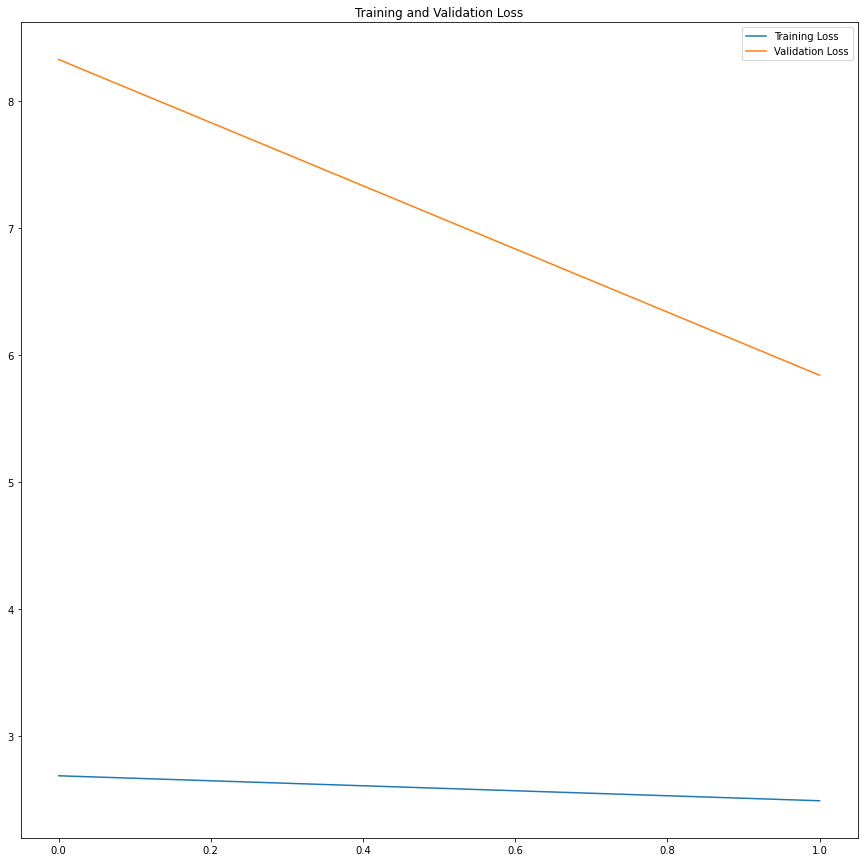

In [24]:
name = 'test'
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(15, 15))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.savefig(f'{name}_accuracy_results.png')
plt.clf();

plt.figure(figsize=(15, 15))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig(f'{name}_loss_results.png')
np.save(f'{name}_training_history.npy', history.history)

In [6]:
model_rgb = keras.Sequential(
    [
        layers.Conv2D(128, kernel_size=(3, 4), input_shape=(120, 160, 3), strides=(1, 1), padding='valid',
                      activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.BatchNormalization(),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(200, activation='relu'),
        layers.Dense(100, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(10, activation='softmax'),
    ]
)

model_rgb.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS),
    loss='categorical_crossentropy', metrics=["accuracy"],
)
model_rgb.summary()
model_rgb.load_weights('rgb_only_new_weights.h5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 118, 157, 128)     4736      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 59, 78, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 59, 78, 64)        73792     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 59, 78, 32)        18464     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 29, 39, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 29, 39, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 29, 39, 32)       

In [41]:
res = model_rgb.predict(X_train)

In [19]:
np.argmax(res[2])

4

In [30]:
len(y_train)

10911

In [25]:
i = 10
print(f'predicted : {np.argmax(res[i])}. Real : {np.argmax(y_val[i])}')

predicted : 4. Real : 4


In [39]:
counter = 0
for i in range(len(y_train)):
    if np.argmax(res[i]) == np.argmax(y_train[i]):
        counter = counter + 1
counter = counter / len(y_train)
counter

0.9593987718815874

In [2]:
array = np.load('test2/rgb/scroll_down/2021-10-14-103320_0/5.npy')

In [4]:
array.shape

(258,)